In [1]:
# Pure python modules and jupyter notebook functionality
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%matplotlib inline
import os
import datetime 
import pandas as pd
from os import path
import numpy as np
import sys
import xarray as xr
from matplotlib import pyplot as plt
from shyft.hydrology import shyftdata_dir
shyft_data_path = os.path.abspath("../../../../shyft-data/")
if path.exists(shyft_data_path) and 'SHYFT_DATA' not in os.environ:
    os.environ['SHYFT_DATA']=shyft_data_path
import time
import shyft
import shyft.time_series as sts
import shyft.hydrology as api
from shyft.hydrology.pt_st_k import PTSTKModel
from shyft.hydrology.repository.default_state_repository import DefaultStateRepository
from shyft.hydrology.orchestration.configuration.yaml_configs import YAMLSimConfig, YAMLCalibConfig
from shyft.hydrology.orchestration.simulators.config_simulator import ConfigSimulator, ConfigCalibrator

# 1. Configuration of simulation

In [2]:
discretization = 'tin' #regular, tin
discretization_size = 'tin_1071' # NB! Only for tin (small, average, bigger, largest)
model_stack = 'ptgsk' #ptgsk, ptstk
simulation_time = 10 #10, 15 years
calibration_time = 5 #5 years
calibration_resolution = 'daily' # daily, hourly

In [3]:
description = f'{discretization_size}_{discretization}_{model_stack}_{calibration_resolution}'
yaml_dir = shyftdata_dir + '/budhi_gandaki/yaml_config'
if discretization == 'tin':
    sim_path = yaml_dir + f'/{discretization}/{model_stack}/{calibration_resolution}/{discretization_size}/budhi_gandaki_simulation_tin.yaml'
    calib_path = yaml_dir + f'/{discretization}/{model_stack}/{calibration_resolution}/{discretization_size}/budhi_gandaki_calibration_tin.yaml'
elif discretization == 'regular':
    sim_path = yaml_dir + f'/{discretization}/{model_stack}/{simulation_time}s_{calibration_time}c_{calibration_resolution}/{discretization_size}/budhi_gandaki_simulation.yaml'
    calib_path = yaml_dir + f'/{discretization}/{model_stack}/{simulation_time}s_{calibration_time}c_{calibration_resolution}/{discretization_size}/budhi_gandaki_calibration.yaml'

print(f'Description: {description}') 
print(f'Simulation path: {sim_path}')
print(f'Calibration path: {calib_path}')

Description: tin_1071_tin_ptgsk_daily
Simulation path: /uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config/tin/ptgsk/daily/tin_1071/budhi_gandaki_simulation_tin.yaml
Calibration path: /uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config/tin/ptgsk/daily/tin_1071/budhi_gandaki_calibration_tin.yaml


In [4]:
cfg_sim = YAMLSimConfig(sim_path, "budhi_gandaki")
simulator = ConfigSimulator(cfg_sim)
cfg_calib = YAMLCalibConfig(calib_path, 'budhi_gandaki')

vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
bare
vegetation_type_1
bare
bare
snow_and_ice
bare
vegetation_type_1
vegetation_type_1
crop_type_2
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
vegetation_type_1
bare
vegetatio

/uio/hume/student-u63/jacobqs/pyenv/lib64/python3.10/site-packages/mst_himalaya/cf_region_model_repository_tin.py:108: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bb_proj = pyproj.transform(target_proj, data_proj, bbox[0], bbox[1])
/uio/hume/student-u63/jacobqs/pyenv/lib64/python3.10/site-packages/mst_himalaya/cf_region_model_repository_tin.py:118: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xx, yy = pyproj.transform(data_proj, target_proj, x, y)


# 2. Running simulation

In [5]:
print('Running simulation...')
simulator.run()
print('Simulation finished running ')

Running simulation...
Running simulation...
Simulation finished running 


# 3. Post-processing and data extraction

####  Visualizing the discharge for the catchment

In [44]:
region_model = simulator.region_model
disc_calib = region_model.statistics.discharge([10]).values
parameters = region_model.get_region_parameter()
parameters.gs.tx = 4.0
simulator.run()
disc_high_tx = region_model.statistics.discharge([10]).values
print(disc_calib)
print(disc_high_tx)

Running simulation...
[107.70702895 107.56089818 107.41069642 ...  29.52691559  29.51108042
  29.49526157]
[107.70702895 107.56089818 107.41069642 ...  42.85256883  42.82702981
  42.80071004]


In [39]:
q_10_ts = region_model.statistics.discharge([10]).values
q_10_np = q_10_ts.values
q_10_ts.values

[107.70702895 107.56089818 107.41069642 ...  29.52691559  29.51108042
  29.49526157]

##### Timeseries

Text(0, 0.5, 'discharge [m3 s-1]')

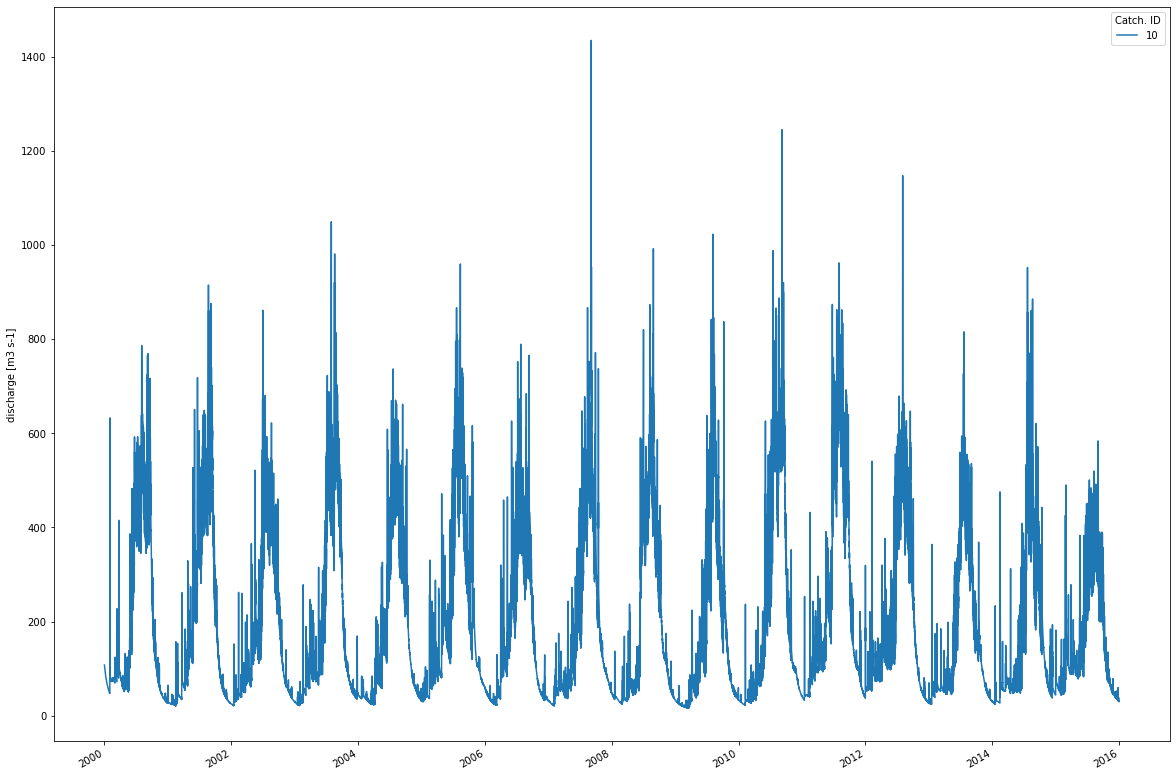

In [8]:
# We can make a quick plot of the data of each sub-catchment
fig, ax = plt.subplots(figsize=(20,15))

timestamps = [region_model.time_axis.time(i) for i in range(0, region_model.time_axis.n)]
ts_timestamps = [datetime.datetime.utcfromtimestamp(p.seconds) for p in timestamps]

# plot each catchment discharge in the catchment_ids
for i,cid in enumerate(region_model.catchment_ids):
    # a ts.time_axis can be enumerated to it's UtcPeriod, 
    # that will have a .start and .end of type utctimestamp
    # to use matplotlib support for datetime-axis, we convert it to datetime (as above)

    data = region_model.statistics.discharge([int(cid)]).values

    ax.plot(ts_timestamps,data, label = "{}".format(region_model.catchment_ids[i]))

fig.autofmt_xdate()
ax.legend(title="Catch. ID")
ax.set_ylabel("discharge [m3 s-1]")

##### Catchment map

In [9]:
cells = region_model.get_cells()

# Once we have the cells, we can get their coordinate information
# and fetch the x- and y-location of the cells
x = np.array([cell.geo.mid_point().x for cell in cells])
y = np.array([cell.geo.mid_point().y for cell in cells])

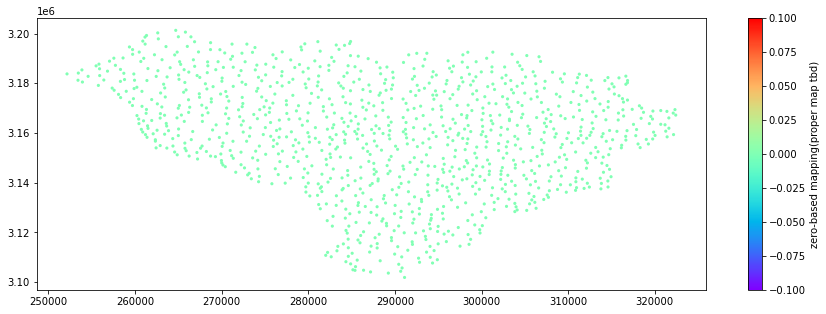

In [10]:
 # let's create the mapping of catchment_id to an integer:
catchment_ids = region_model.catchment_ids
cid_z_map = dict([ (catchment_ids[i],i) for i in range(len(catchment_ids))])

# then create an array the same length as our 'x' and 'y', which holds the
# integer value that we'll use for the 'z' value
catch_ids = np.array([cid_z_map[cell.geo.catchment_id()] for cell in cells])

# and make a quick catchment map...
# using a scatter plot of the cells
fig, ax = plt.subplots(figsize=(15,5))
cm = plt.cm.get_cmap('rainbow')
plot = ax.scatter(x, y, c=catch_ids, marker='.', s=40, lw=0, cmap=cm)
plt.colorbar(plot).set_label('zero-based mapping(proper map tbd)')

##### Snow-cover

Text(0.5, 1.0, 'Snow Covered area of budhi_gandaki_average_tin_ptgsk_10s_5c_daily on 2011-02-15T00:00:00+01')

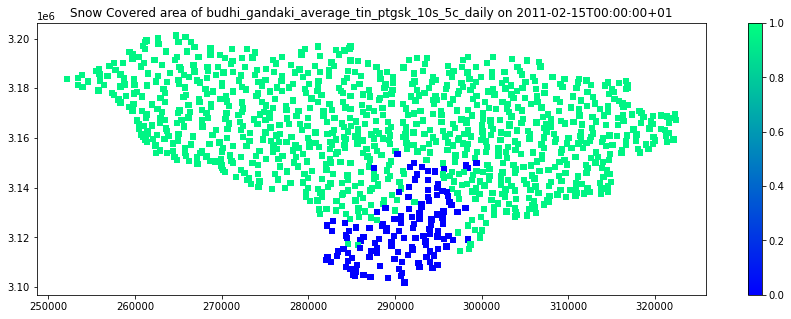

In [11]:
#first, set a date: year, month, day, (hour of day if hourly time step)
oslo = sts.Calendar('Europe/Oslo') # specifying input calendar in Oslo tz-id
time_x = oslo.time(2011,2,15)  # the oslo calendar(incl dst) converts calendar coordinates Y,M,D.. to its utc-time

# we need to get the index of the time_axis for the time
try:
    idx = simulator.region_model.time_axis.index_of(time_x) # index of time x on time-axis
except:
    print("Date out of range, setting index to 0")
    idx = 0

# fetching SCA (the response variable is named "snow_sca")
# You can use tab-completion to explore the `rc`, short for "response collector"
# object of the cell, to see further response variables available.
# specifying empty list [] indicates all catchments, otherwise pass catchment_id
sca = simulator.region_model.statistics.snow_sca([],idx)

# We can make a simple scatter plot again for quick visualization
fig, ax = plt.subplots(figsize=(15,5))
cm = plt.cm.get_cmap('winter')
plot = ax.scatter(x, y, c=sca, 
                  vmin=0, vmax=1, 
                  marker='s', s=40, lw=0, 
                  cmap=cm)
plt.colorbar(plot)
plt.title('Snow Covered area of {0} on {1}'.format(cfg_sim.region_model_id, oslo.to_string(time_x)))


Average SCA for Budhi Gandaki: 0.8452661064425773


Text(0, 0.5, 'frequency')

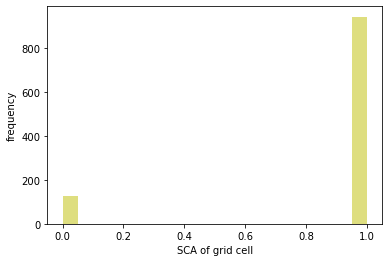

In [12]:
# look at the catchment-wide average:
nea_avg_sca = np.average(sca)
print("Average SCA for Budhi Gandaki: {0}".format(nea_avg_sca))

# And let's compute histogram of the snow covered area as well
fig, ax = plt.subplots()
ax.hist(sca, bins=20, range=(0,1), color='y', alpha=0.5)
ax.set_xlabel("SCA of grid cell")
ax.set_ylabel("frequency")

# 4. Configuration of Shyft calibration

In [29]:
state = simulator.region_model.state

In [30]:
calib = ConfigCalibrator(cfg_calib)
n_cells = calib.region_model.size()
state_repos = DefaultStateRepository(calib.region_model)

vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
bare
vegetation_type_1
bare
bare
snow_and_ice
bare
vegetation_type_1
vegetation_type_1
crop_type_2
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
snow_and_ice
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
vegetation_type_1
bare
vegetation_type_1
vegetation_type_1
bare
vegetatio

/uio/hume/student-u63/jacobqs/pyenv/lib64/python3.10/site-packages/mst_himalaya/cf_region_model_repository_tin.py:108: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bb_proj = pyproj.transform(target_proj, data_proj, bbox[0], bbox[1])
/uio/hume/student-u63/jacobqs/pyenv/lib64/python3.10/site-packages/mst_himalaya/cf_region_model_repository_tin.py:118: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xx, yy = pyproj.transform(data_proj, target_proj, x, y)


Creating TargetSpecificationVector...


# 5. Running Shyft calibration

In [18]:
st = time.time()
results = calib.calibrate(cfg_calib.sim_config.time_axis, state_repos.get_state(0), 
                          cfg_calib.optimization_method['name'],
                          cfg_calib.optimization_method['params'])
et = time.time()
elapsed_time = et - st

Calibrating...
Storing calibrated params in: /uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/budhi_gandaki/yaml_config/tin/ptgsk/daily/tin_1071/calibrated_model.yaml


# 6. Inspecting the calibration results

In [19]:
 # Get NSE of calibrated run:
result_params = []
for i in range(results.size()):
    result_params.append(results.get(i))
print("Final NSE =", 1-calib.optimizer.calculate_goal_function(result_params))

Final NSE = 0.8951783684286285


In [20]:
# Check out the calibrated parameters.

diff = 1.0E-3
print("{0:30s} {1:10s}".format("PARAM-NAME", "CALIB-VALUE"))

for i in range(results.size()):
    print("{0:30s} {1:10f}".format(results.get_name(i), results.get(i)))

PARAM-NAME                     CALIB-VALUE
kirchner.c1                     -5.691155
kirchner.c2                      0.172316
kirchner.c3                     -0.096800
ae.ae_scale_factor               1.000000
gs.tx                           -2.971491
gs.wind_scale                    5.304488
gs.max_water                     0.100000
gs.wind_const                    1.000000
gs.fast_albedo_decay_rate       11.738913
gs.slow_albedo_decay_rate       34.652496
gs.surface_magnitude            30.000000
gs.max_albedo                    0.900000
gs.min_albedo                    0.600000
gs.snowfall_reset_depth          5.000000
gs.snow_cv                       0.400000
gs.glacier_albedo                0.400000
p_corr.scale_factor              1.306775
gs.snow_cv_forest_factor         0.000000
gs.snow_cv_altitude_factor       0.000000
pt.albedo                        0.200000
pt.alpha                         1.260000
gs.initial_bare_ground_fraction   0.040000
gs.winter_end_day_of_year      1

# 7. Plotting simulated vs observed discharge

In [21]:
# get the target vector and discharge statistics from the configured calibrator
target_obs = calib.tv[0]
disch_sim = calib.region_model.statistics.discharge(target_obs.catchment_indexes)
disch_obs = target_obs.ts.values


ts_timestamps_sim = [datetime.datetime.utcfromtimestamp(p) for p in disch_sim.time_axis.time_points]
ts_timestamps_sim = ts_timestamps_sim[:-1]

ts_timestamps_obs = [datetime.datetime.utcfromtimestamp(p) for p in target_obs.ts.time_axis.time_points]
ts_timestamps_obs = ts_timestamps_obs[:-1]

# 8. Saving results as a netcdf file

In [22]:
# Extracting values
disch_sim = calib.region_model.statistics.discharge(target_obs.catchment_indexes)
precip_sim = calib.region_model.statistics.precipitation(target_obs.catchment_indexes)
temp_sim = calib.region_model.statistics.temperature(target_obs.catchment_indexes)
rad_sim = calib.region_model.statistics.radiation(target_obs.catchment_indexes)
rel_hum_sim = calib.region_model.statistics.rel_hum(target_obs.catchment_indexes)
wind_speed_sim = calib.region_model.statistics.wind_speed(target_obs.catchment_indexes)
elev_sim = calib.region_model.statistics.elevation(target_obs.catchment_indexes)
snow_sca_sim = calib.region_model.statistics.snow_sca(target_obs.catchment_indexes)
snow_swe_sim = calib.region_model.statistics.snow_swe(target_obs.catchment_indexes)
forest_area_sim = calib.region_model.statistics.forest_area(target_obs.catchment_indexes)
glacier_area_sim = calib.region_model.statistics.glacier_area(target_obs.catchment_indexes)
lake_area_sim = calib.region_model.statistics.lake_area(target_obs.catchment_indexes)
total_area_sim = calib.region_model.statistics.total_area(target_obs.catchment_indexes)
unspecified_area_sim = calib.region_model.statistics.unspecified_area(target_obs.catchment_indexes)
charge_sim = calib.region_model.statistics.charge(target_obs.catchment_indexes)
reservoir_area_sim = calib.region_model.statistics.reservoir_area(target_obs.catchment_indexes)
disch_obs = target_obs.ts.values

In [23]:
# Extracting time
ts_timestamps_sim = [datetime.datetime.utcfromtimestamp(p) for p in disch_sim.time_axis.time_points]
ts_timestamps_sim = ts_timestamps_sim[:-1]


ts_timestamps_obs = [datetime.datetime.utcfromtimestamp(p) for p in target_obs.ts.time_axis.time_points]
ts_timestamps_obs = ts_timestamps_obs[:-1]

In [24]:
start_time = str(cfg_calib.sim_config.start_datetime)[:10]
run_time_step = str(cfg_calib.sim_config.run_time_step)
number_of_steps = str(cfg_calib.sim_config.number_of_steps)

In [25]:
number_of_steps

'140256'

In [26]:
calib_params_range = cfg_calib.calibration_parameters

In [27]:
# Save parameters
params = dict()
for i in range(results.size()):
    params[results.get_name(i)] = results.get(i)

In [28]:
#d_o = xr.open_mfdataset('/uio/hume/student-u63/jacobqs/Master/code/MST-Himalaya/shyft_workspace_copy/shyft_workspace/shyft-data/netcdf/orchestration-testdata/discharge.nc')

In [ ]:
#d_o.time

In [29]:

ds_sim = xr.Dataset(
    data_vars = dict(
        temperature = (['time'], temp_sim.values),
        precipitation = (['time'], precip_sim.values),
        wind_speed = (['time'], wind_speed_sim.values),
        radiation = (['time'], rad_sim.values),
        relative_humidity = (['time'], rel_hum_sim.values),
        disch_sim = (['time'], disch_sim.values),
        #calibration_parameter_range = ([], calib_params_range),
        #optimal_parameters = ([], params),
    ),
    coords = dict(
        time = (['time'],ts_timestamps_sim )
    ),
    attrs = dict(description = description,
                 calib_start_time = start_time,
                 calib_run_time_step = run_time_step,
                 calib_number_of_steps = number_of_steps,
                 nse = 1 - calib.optimizer.calculate_goal_function(result_params),
                 elevation = str(elev_sim) + ' m.a.s.l.',
                 forest_area = str(forest_area_sim) + ' m^2',
                 glacier_area = str(glacier_area_sim) + ' m^2',
                 lake_area = str(lake_area_sim) + ' m^2',
                 total_area = str(total_area_sim) + ' m^2',
                 unspecified_area = str(unspecified_area_sim) + ' m^2',
                 reservoir_area = str(reservoir_area_sim) + ' m^2',
                kirchner_c1 = params['kirchner.c1'],
                kirchner_c2 = params['kirchner.c2'],
                kirchner_c3 = params['kirchner.c3'],
                gm_direct_response = params['gm.direct_response'],
                gm_dtf = params['gm.dtf'],
                ae_scale_factor = params['ae.ae_scale_factor'],
                n_winter_days = params['gs.n_winter_days'],
                iso_pot_energy = params['gs.calculate_iso_pot_energy'],
                glacier_albedo= params['gs.glacier_albedo'],
                init_bare_ground_fraction = params['gs.initial_bare_ground_fraction'],
                max_albedo = params['gs.max_albedo'],
                max_water = params['gs.max_water'],
                min_albedo = params['gs.min_albedo'],
                slow_albedo_decay_rate = params['gs.slow_albedo_decay_rate'],
                fast_albedo_decay_rate = params['gs.fast_albedo_decay_rate'],
                snow_cv = params['gs.snow_cv'],
                snow_cv_altitude_factor = params['gs.snow_cv_altitude_factor'],
                snow_cv_forest_factor = params['gs.snow_cv_forest_factor'],
                snowfall_reset_depth = params['gs.snowfall_reset_depth'],
                surface_magnitude = params['gs.surface_magnitude'],
                tx = params['gs.tx'],
                wind_const = params['gs.wind_const'],
                wind_scale = params['gs.wind_scale'],
                winter_end_day_of_year = params['gs.winter_end_day_of_year'],
                msp_reservoir_direct_response_fraction = params['msp.reservoir_direct_response_fraction'],
                p_corr = params['p_corr.scale_factor'],
                pt_albedo = params['pt.albedo'],
                pt_alpha = params['pt.alpha'],
                routing_velocity = params['routing.velocity'],
                routing_alpha = params['routing.alpha'],
                routing_beta = params['routing.beta'],
                calib_run_time = elapsed_time
                
                
))

In [ ]:
# ds_obs = xr.Dataset(
#     data_vars = dict(
#         discharge_observed = (['time'], disch_obs),
#     ),
#     coords = dict(
#         time = (['time'],ts_timestamps_obs )
#     )
# )

In [ ]:
print(description)

tin_largesttin_ptstk


In [30]:
ds_sim.to_netcdf(path = f'{shyftdata_dir}/SIMULATIONS/{description}_new.nc' ,
                 format = 'NETCDF4')

In [31]:
new_ds = xr.open_mfdataset(f'{shyftdata_dir}/SIMULATIONS/{description}_new.nc')

In [34]:
new_ds

<xarray.Dataset>
Dimensions:            (time: 140256)
Coordinates:
  * time               (time) datetime64[ns] 2000-01-01 ... 2015-12-31T23:00:00
Data variables:
    temperature        (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    precipitation      (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    wind_speed         (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    radiation          (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    relative_humidity  (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    disch_sim          (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
Attributes: (12/44)
    description:                             tin_1071_tin_ptgsk_daily
    calib_start_time:                        2000-01-01
    calib_run_time_step:                     3600
    calib_number_of_steps:                   140256
    nse:                                     0.8951783684286285
    elevation:                               4270.8034922798215 m.a.s.l.
    ...                                      ...
    pt_albedo:                               0.2
    pt_alpha:                                1.26
    routing_velocity:                        0.0
    routing_alpha:                           0.9
    routing_beta:                            3.0
    calib_run_time:                          7648.434473276138

# Post-calibration run

In [15]:
ae = simulator.region_model.actual_evaptranspiration_response.output([10]).values
gm = simulator.region_model.gamma_snow_response.glacier_melt([10]).values
outflow = simulator.region_model.gamma_snow_response.outflow([10]).values
sca = simulator.region_model.gamma_snow_response.sca([10]).values
swe = simulator.region_model.gamma_snow_response.swe([10]).values
pt = simulator.region_model.priestley_taylor_response.output([10]).values
disch_sim = simulator.region_model.statistics.discharge([10]).values
radiation = simulator.region_model.statistics.radiation([10]).values
wind_speed = simulator.region_model.statistics.wind_speed([10]).values
rel_hum = simulator.region_model.statistics.rel_hum([10]).values
temp = simulator.region_model.statistics.temperature([10]).values
precip = simulator.region_model.statistics.precipitation([10]).values
timestamps = [region_model.time_axis.time(i) for i in range(0, region_model.time_axis.n)]
ts_timestamps = [datetime.datetime.utcfromtimestamp(p.seconds) for p in timestamps]


In [16]:

ds_post_calib = xr.Dataset(
    data_vars = dict(
        temperature = (['time'], temp),
        precipitation = (['time'], precip),
        wind_speed = (['time'], wind_speed),
        radiation = (['time'], radiation),
        relative_humidity = (['time'], rel_hum),
        discharge = (['time'], disch_sim),
        sca = (['time'], sca),
        swe = (['time'], swe),
        pt = (['time'], pt),
        outflow = (['time'], outflow),
        glacier_melt = (['time'], gm),
        actual_evapotranspiration = (['time'], ae)
        #calibration_parameter_range = ([], calib_params_range),
        #optimal_parameters = ([], params),
    ),
    coords = dict(
        time = (['time'],ts_timestamps)
    ),
    attrs = dict(description = new_ds.description,
                 calib_start_time = new_ds.calib_start_time,
                 calib_run_time_step = new_ds.calib_run_time_step,
                 calib_number_of_steps = new_ds.calib_number_of_steps,
                 nse = new_ds.nse,
                 elevation = new_ds.elevation,
                 forest_area = new_ds.forest_area,
                 glacier_area = new_ds.glacier_area,
                 lake_area = new_ds.lake_area,
                 total_area = new_ds.total_area,
                 unspecified_area = new_ds.unspecified_area,
                 reservoir_area = new_ds.reservoir_area,
                kirchner_c1 = new_ds.kirchner_c1,
                kirchner_c2 = new_ds.kirchner_c2,
                kirchner_c3 = new_ds.kirchner_c3,
                gm_direct_response = new_ds.gm_direct_response,
                gm_dtf = new_ds.gm_dtf,
                ae_scale_factor = new_ds.ae_scale_factor,
                n_winter_days = new_ds.n_winter_days,
                iso_pot_energy = new_ds.iso_pot_energy,
                glacier_albedo= new_ds.glacier_albedo,
                init_bare_ground_fraction = new_ds.init_bare_ground_fraction,
                max_albedo = new_ds.max_albedo,
                max_water = new_ds.max_water,
                min_albedo = new_ds.min_albedo,
                slow_albedo_decay_rate = new_ds.slow_albedo_decay_rate,
                fast_albedo_decay_rate = new_ds.fast_albedo_decay_rate,
                snow_cv = new_ds.snow_cv,
                snow_cv_altitude_factor = new_ds.snow_cv_altitude_factor,
                snow_cv_forest_factor = new_ds.snow_cv_forest_factor,
                snowfall_reset_depth = new_ds.snowfall_reset_depth,
                surface_magnitude = new_ds.surface_magnitude,
                tx = new_ds.tx,
                wind_const = new_ds.wind_const,
                wind_scale = new_ds.wind_scale,
                winter_end_day_of_year = new_ds.winter_end_day_of_year,
                msp_reservoir_direct_response_fraction = new_ds.msp_reservoir_direct_response_fraction,
                p_corr = new_ds.p_corr,
                pt_albedo = new_ds.pt_albedo,
                pt_alpha = new_ds.pt_alpha,
                routing_velocity = new_ds.routing_velocity,
                routing_alpha = new_ds.routing_alpha,
                routing_beta = new_ds.routing_beta,
                calib_run_time = '230m 14.4s'
                
                
))

In [17]:
ds_post_calib.to_netcdf(path = f'{shyftdata_dir}/SIMULATIONS/{description}_sim_post_calib.nc' ,
                 format = 'NETCDF4')

In [18]:
ds = xr.open_mfdataset(f'{shyftdata_dir}/SIMULATIONS/{description}_sim_post_calib.nc')
ds

<xarray.Dataset>
Dimensions:                    (time: 140256)
Coordinates:
  * time                       (time) datetime64[ns] 2000-01-01 ... 2015-12-3...
Data variables:
    temperature                (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    precipitation              (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    wind_speed                 (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    radiation                  (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    relative_humidity          (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    discharge                  (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    sca                        (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    swe                        (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    pt                         (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    outflow                    (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    glacier_melt               (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
    actual_evapotranspiration  (time) float64 dask.array<chunksize=(140256,), meta=np.ndarray>
Attributes: (12/44)
    description:                             average_tin_ptgsk_10s_5c_daily
    calib_start_time:                        2000-01-01
    calib_run_time_step:                     3600
    calib_number_of_steps:                   87658
    nse:                                     0.8951804813764399
    elevation:                               4270.8034922798215 m.a.s.l.
    ...                                      ...
    pt_albedo:                               0.2
    pt_alpha:                                1.26
    routing_velocity:                        0.0
    routing_alpha:                           0.9
    routing_beta:                            3.0
    calib_run_time:                          230m 14.4s

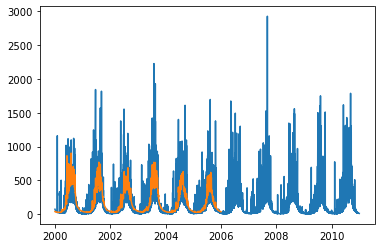

In [150]:
plt.plot(ds_sim.time, ds_sim.discharge_simulated)
plt.plot(ds_obs.time, ds_obs.discharge_observed)

In [151]:
time_obs = ts_timestamps_obs
time_sim = ts_timestamps_sim
disch_sim = disch_sim

Text(0, 0.5, 'discharge [m3 s-1]')

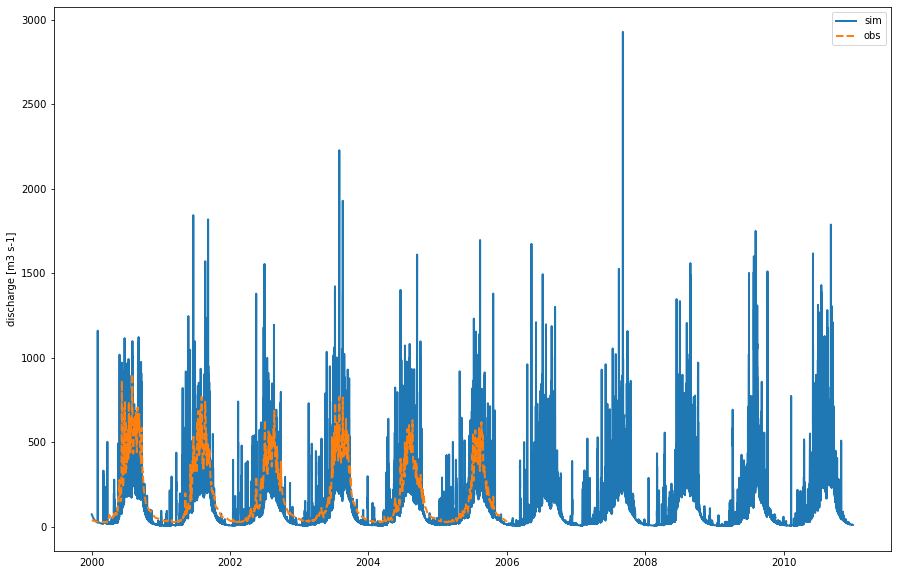

In [152]:
 # plot up the results
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps_sim, disch_sim.values, lw=2, label = "sim")
ax.plot(ts_timestamps_obs, disch_obs, lw=2, ls='--', label = "obs")
#ax.set_title("observed and simulated discharge")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

# 8. Changing parameters on-the-fly

In [27]:
parameters = region_model.get_region_parameter() # fetching parameters from the simulator object
print(u"Calibrated rain/snow threshold temp: {} C".format(parameters.gs.tx)) # print current value of hs.tx

Calibrated rain/snow threshold temp: -2.971491314753611 C


### st.tx

In [34]:
cfg_sim.model_config.model_parameters()

{'ae': {'ae_scale_factor': 1.0},
 'gm': {'direct_response': 0.5237029827867703, 'dtf': 6.0},
 'gs': {'calculate_iso_pot_energy': False,
  'fast_albedo_decay_rate': 11.738913029640742,
  'glacier_albedo': 0.4,
  'initial_bare_ground_fraction': 0.04,
  'max_albedo': 0.9,
  'max_water': 0.1,
  'min_albedo': 0.6,
  'n_winter_days': 100,
  'slow_albedo_decay_rate': 34.65249572617281,
  'snow_cv': 0.4,
  'snow_cv_altitude_factor': 0.0,
  'snow_cv_forest_factor': 0.0,
  'snowfall_reset_depth': 5.0,
  'surface_magnitude': 30.0,
  'tx': -2.971491314753611,
  'wind_const': 1.0,
  'wind_scale': 5.3044882850702715,
  'winter_end_day_of_year': 100},
 'kirchner': {'c1': -5.691154600465198,
  'c2': 0.1723159130746843,
  'c3': -0.09679996710363575},
 'msp': {'reservoir_direct_response_fraction': 1.0},
 'p_corr': {'scale_factor': 1.3067752201633134},
 'pt': {'albedo': 0.2, 'alpha': 1.26},
 'routing': {'alpha': 0.9, 'beta': 3.0, 'velocity': 0.0}}

In [36]:
#calib.optimizer.calculate_goal_function() # reset the parameters to the values of the calibration
parameters.gs.tx = 4.0 # setting a higher value for tx
s_init = state.extract_state([])
# type(state)
# s0=state_repos.get_state(0)
# s0.state_vector
# state.apply_state(s0, [])
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
parameters.gs.tx = -4.0 # setting a higher value for tx

calib.run(state=s_init) # rerun the model, with new parameter

disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
calib.run(state=s_init) 
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps_sim, disch_sim.values, lw=2, label = "Calibrated model (TIN-1071 PTGSK)")
ax.plot(ts_timestamps_sim, disch_sim_p_high.values, lw=2, label = "Max gs.tx value (4.0)")
ax.plot(ts_timestamps_sim, disch_sim_p_low.values, lw=2, label = "Min gs.tx value (-4.0)")
ax.plot(ts_timestamps_obs, disch_obs, lw=2, ls='--', label = "Observed")
#ax.set_title("investigating parameter st.tx")
ax.legend()
ax.set_ylabel("Discharge [m$^3$/s]")
ax.set_xlabel('Year')

plt.tight_layout()
plt.show()


TypeError: 'method' object is not iterable

### P_corr

In [37]:
calib.optimizer.calculate_goal_function() # reset the parameters to the values of the calibration
parameters.p_corr.scale_factor = 2.0 # setting a higher value for tx
s_init = state.extract_state([])
# type(state)
# s0=state_repos.get_state(0)
# s0.state_vector
# state.apply_state(s0, [])
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
parameters.p_corr.scale_factor = 0.4 # setting a lower value for p_corr

calib.run(state=s_init) # rerun the model, with new parameter

disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
calib.run(state=s_init) 
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps_sim, disch_sim.values, lw=2, label = "calib")
ax.plot(ts_timestamps_sim, disch_sim_p_high.values, lw=2, label = "high")
ax.plot(ts_timestamps_sim, disch_sim_p_low.values, lw=2, label = "low")
ax.plot(ts_timestamps_obs, disch_obs, lw=2, ls='--', label = "obs")
#ax.set_title("investigating parameter st.tx")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

ArgumentError: Python argument types in
    PTGSKOptimizer.calculate_goal_function(PTGSKOptimizer)
did not match C++ signature:
    calculate_goal_function(expose::model_calibrator<shyft::core::region_model<shyft::core::cell<shyft::core::pt_gs_k::parameter, shyft::core::environment<shyft::time_axis::fixed_dt, shyft::time_series::point_ts<shyft::time_axis::fixed_dt>, shyft::time_series::point_ts<shyft::time_axis::fixed_dt>, shyft::time_series::point_ts<shyft::time_axis::fixed_dt>, shyft::time_series::point_ts<shyft::time_axis::fixed_dt>, shyft::time_series::point_ts<shyft::time_axis::fixed_dt> >, shyft::core::pt_gs_k::state, shyft::core::pt_gs_k::null_collector, shyft::core::pt_gs_k::discharge_collector>, shyft::api::a_region_environment> >(char const*)::Optimizer {lvalue} self, shyft::core::pt_gs_k::parameter parameters)
    calculate_goal_function(expose::model_calibrator<shyft::core::region_model<shyft::core::cell<shyft::core::pt_gs_k::parameter, shyft::core::environment<shyft::time_axis::fixed_dt, shyft::time_series::point_ts<shyft::time_axis::fixed_dt>, shyft::time_series::point_ts<shyft::time_axis::fixed_dt>, shyft::time_series::point_ts<shyft::time_axis::fixed_dt>, shyft::time_series::point_ts<shyft::time_axis::fixed_dt>, shyft::time_series::point_ts<shyft::time_axis::fixed_dt> >, shyft::core::pt_gs_k::state, shyft::core::pt_gs_k::null_collector, shyft::core::pt_gs_k::discharge_collector>, shyft::api::a_region_environment> >(char const*)::Optimizer {lvalue} self, std::vector<double, std::allocator<double> > full_vector_of_parameters)

### Kirchner c1

Running simulation...
Running simulation...
Running simulation...


Text(0, 0.5, 'discharge [m3 s-1]')

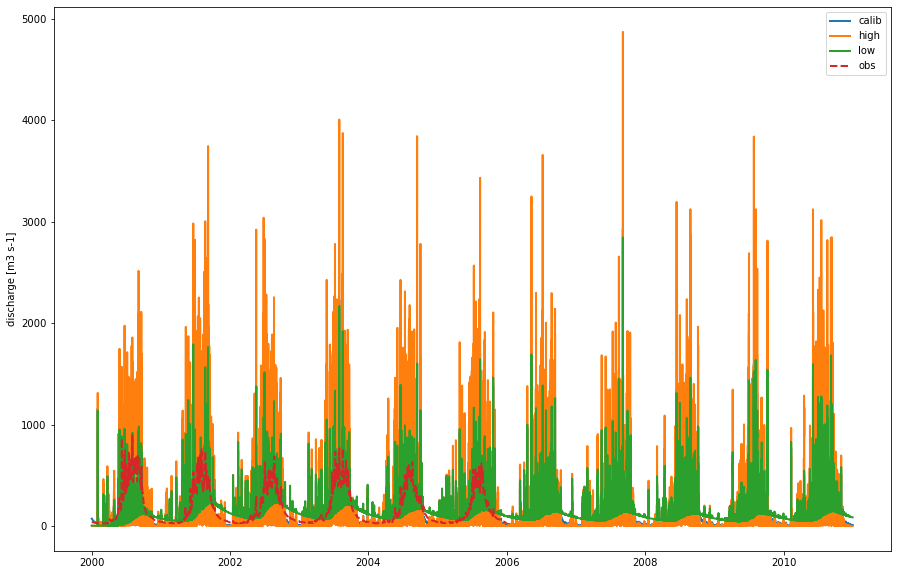

In [156]:
calib.optimizer.calculate_goal_function(result_params) # reset the parameters to the values of the calibration
parameters.kirchner.c1 = 0.0 # setting a higher value for tx
s_init = state.extract_state([])
# type(state)
# s0=state_repos.get_state(0)
# s0.state_vector
# state.apply_state(s0, [])
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
parameters.kirchner.c1 = -8.0 # setting a lower value for p_corr

calib.run(state=s_init) # rerun the model, with new parameter

disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
calib.run(state=s_init) 
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps_sim, disch_sim.values, lw=2, label = "calib")
ax.plot(ts_timestamps_sim, disch_sim_p_high.values, lw=2, label = "high")
ax.plot(ts_timestamps_sim, disch_sim_p_low.values, lw=2, label = "low")
ax.plot(ts_timestamps_obs, disch_obs, lw=2, ls='--', label = "obs")
#ax.set_title("investigating parameter st.tx")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

### Kirchner c2

Running simulation...
Running simulation...
Running simulation...


Text(0, 0.5, 'discharge [m3 s-1]')

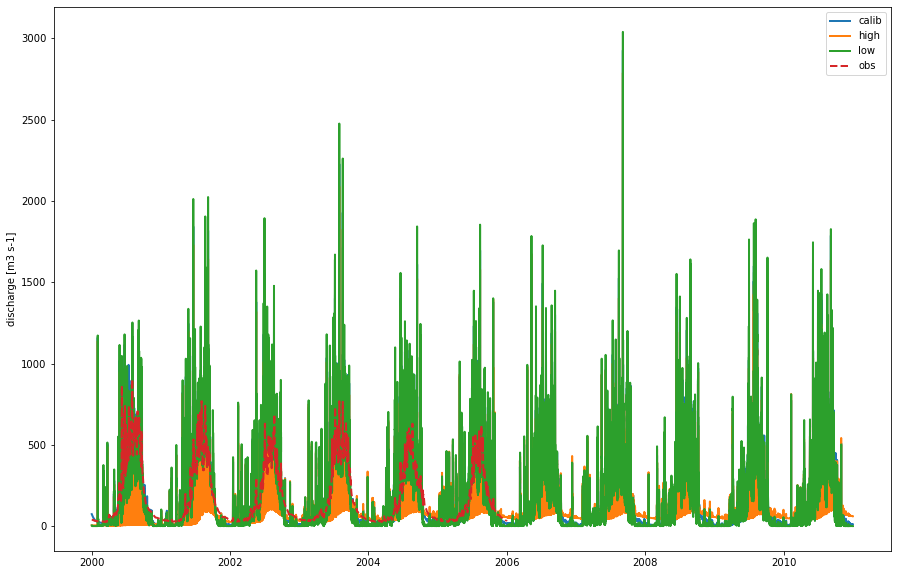

In [157]:
calib.optimizer.calculate_goal_function(result_params) # reset the parameters to the values of the calibration
parameters.kirchner.c2 = 1.2 # setting a higher value for tx
s_init = state.extract_state([])
# type(state)
# s0=state_repos.get_state(0)
# s0.state_vector
# state.apply_state(s0, [])
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
parameters.kirchner.c2 = -1.0 # setting a lower value for p_corr

calib.run(state=s_init) # rerun the model, with new parameter

disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
calib.run(state=s_init) 
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps_sim, disch_sim.values, lw=2, label = "calib")
ax.plot(ts_timestamps_sim, disch_sim_p_high.values, lw=2, label = "high")
ax.plot(ts_timestamps_sim, disch_sim_p_low.values, lw=2, label = "low")
ax.plot(ts_timestamps_obs, disch_obs, lw=2, ls='--', label = "obs")
#ax.set_title("investigating parameter st.tx")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

### Kirchner c3

In [ ]:
simulator.region_model.

Running simulation...
Running simulation...
Running simulation...


Text(0, 0.5, 'discharge [m3 s-1]')

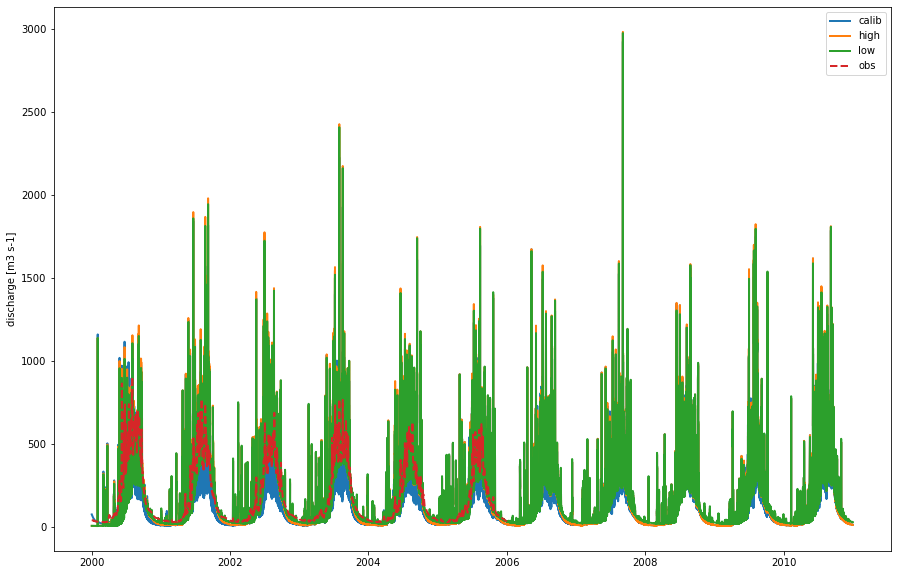

In [158]:
calib.optimizer.calculate_goal_function(result_params) # reset the parameters to the values of the calibration
parameters.kirchner.c3 = -0.05 # setting a higher value for c3
s_init = state.extract_state([])
# type(state)
# s0=state_repos.get_state(0)
# s0.state_vector
# state.apply_state(s0, [])
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
parameters.kirchner.c3 = -0.15 # setting a lower value for p_corr

calib.run(state=s_init) # rerun the model, with new parameter

disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
calib.run(state=s_init) 
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps_sim, disch_sim.values, lw=2, label = "calib")
ax.plot(ts_timestamps_sim, disch_sim_p_high.values, lw=2, label = "high")
ax.plot(ts_timestamps_sim, disch_sim_p_low.values, lw=2, label = "low")
ax.plot(ts_timestamps_obs, disch_obs, lw=2, ls='--', label = "obs")
#ax.set_title("investigating parameter st.tx")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

### ae_scale_factor

Running simulation...
Running simulation...
Running simulation...


Text(0, 0.5, 'discharge [m3 s-1]')

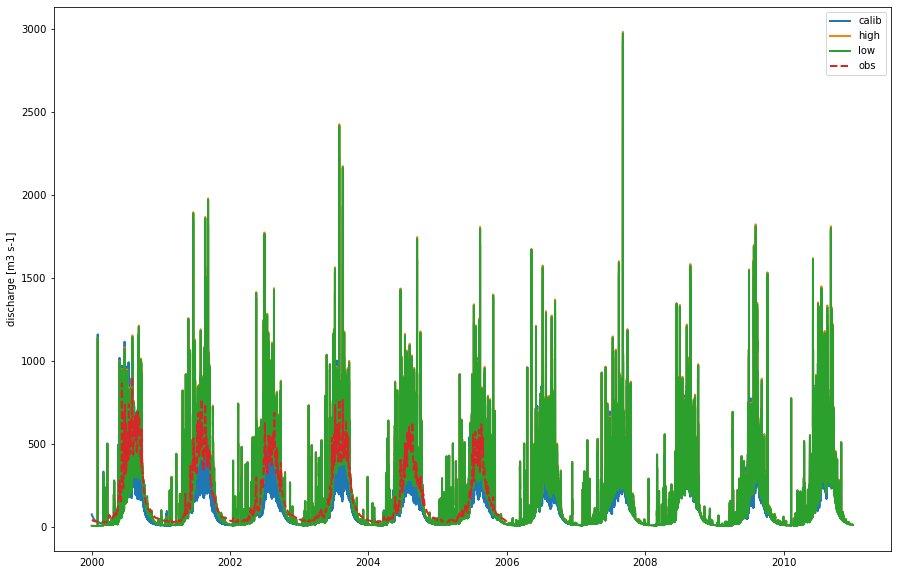

In [159]:
calib.optimizer.calculate_goal_function(result_params) # reset the parameters to the values of the calibration
parameters.ae.ae_scale_factor = 1.5 # setting a higher value for c3
s_init = state.extract_state([])
# type(state)
# s0=state_repos.get_state(0)
# s0.state_vector
# state.apply_state(s0, [])
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
parameters.ae.ae_scale_factor = 1.0 # setting a lower value for p_corr

calib.run(state=s_init) # rerun the model, with new parameter

disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
calib.run(state=s_init) 
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps_sim, disch_sim.values, lw=2, label = "calib")
ax.plot(ts_timestamps_sim, disch_sim_p_high.values, lw=2, label = "high")
ax.plot(ts_timestamps_sim, disch_sim_p_low.values, lw=2, label = "low")
ax.plot(ts_timestamps_obs, disch_obs, lw=2, ls='--', label = "obs")
#ax.set_title("investigating parameter st.tx")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

### st.cx

Running simulation...
Running simulation...
Running simulation...


Text(0, 0.5, 'discharge [m3 s-1]')

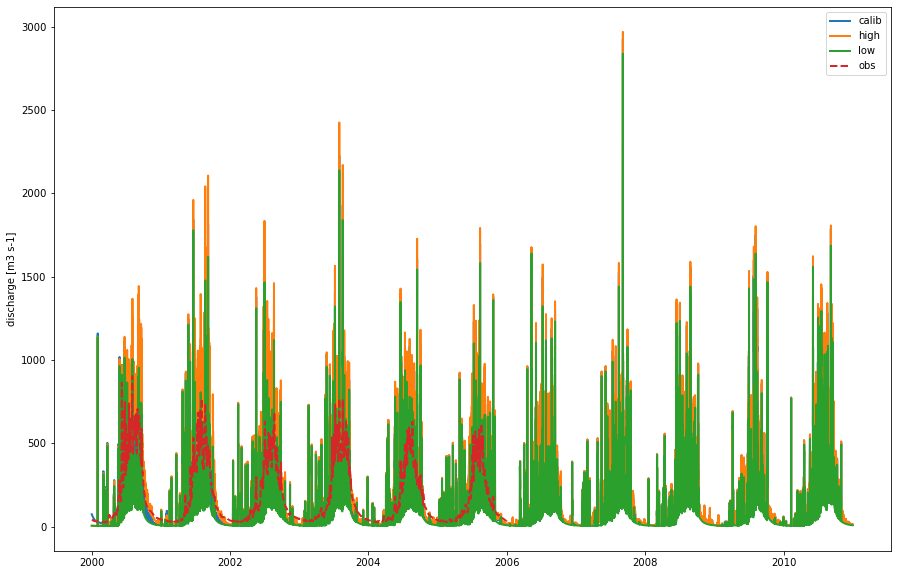

In [160]:
calib.optimizer.calculate_goal_function(result_params) # reset the parameters to the values of the calibration
parameters.st.cx = 30.0 # setting a higher value for c3
s_init = state.extract_state([])
# type(state)
# s0=state_repos.get_state(0)
# s0.state_vector
# state.apply_state(s0, [])
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
parameters.st.cx = 0.0 # setting a lower value for p_corr

calib.run(state=s_init) # rerun the model, with new parameter

disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
calib.run(state=s_init) 
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps_sim, disch_sim.values, lw=2, label = "calib")
ax.plot(ts_timestamps_sim, disch_sim_p_high.values, lw=2, label = "high")
ax.plot(ts_timestamps_sim, disch_sim_p_low.values, lw=2, label = "low")
ax.plot(ts_timestamps_obs, disch_obs, lw=2, ls='--', label = "obs")
#ax.set_title("investigating parameter st.tx")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

### st.ts

Running simulation...
Running simulation...
Running simulation...


Text(0, 0.5, 'discharge [m3 s-1]')

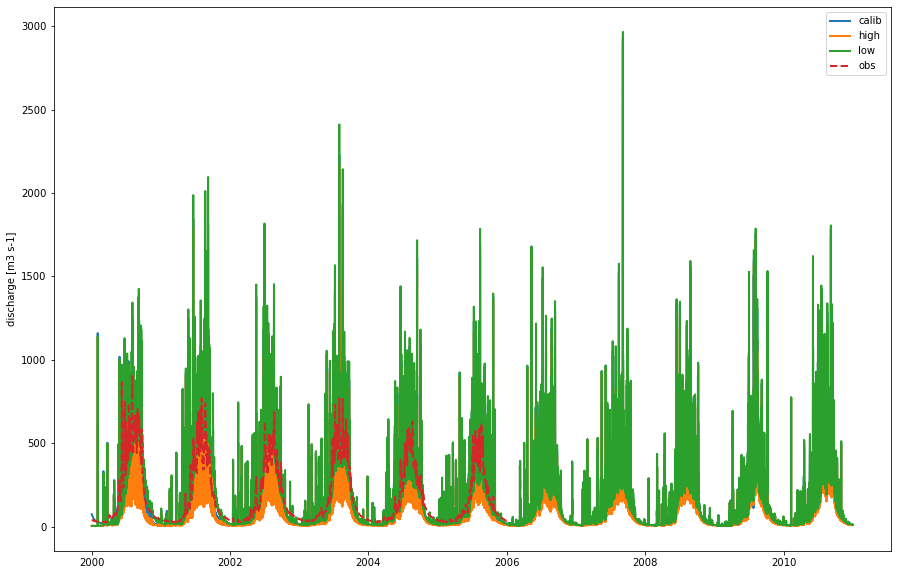

In [161]:
calib.optimizer.calculate_goal_function(result_params) # reset the parameters to the values of the calibration
parameters.st.ts = 4.0 # setting a higher value for st.ts
s_init = state.extract_state([])
# type(state)
# s0=state_repos.get_state(0)
# s0.state_vector
# state.apply_state(s0, [])
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
parameters.st.ts = -4.0 # setting a lower value for st.ts

calib.run(state=s_init) # rerun the model, with new parameter

disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
calib.run(state=s_init) 
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps_sim, disch_sim.values, lw=2, label = "calib")
ax.plot(ts_timestamps_sim, disch_sim_p_high.values, lw=2, label = "high")
ax.plot(ts_timestamps_sim, disch_sim_p_low.values, lw=2, label = "low")
ax.plot(ts_timestamps_obs, disch_obs, lw=2, ls='--', label = "obs")
#ax.set_title("investigating parameter st.tx")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

### lw_max

Running simulation...
Running simulation...
Running simulation...


Text(0, 0.5, 'discharge [m3 s-1]')

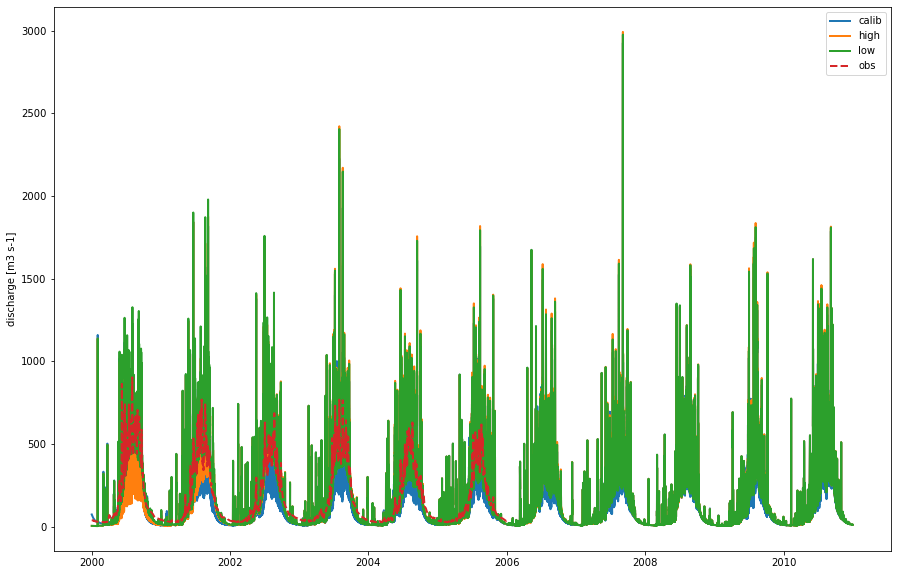

In [162]:
calib.optimizer.calculate_goal_function(result_params) # reset the parameters to the values of the calibration
parameters.st.lwmax = 1.0 # setting a higher value for st.ts
s_init = state.extract_state([])
# type(state)
# s0=state_repos.get_state(0)
# s0.state_vector
# state.apply_state(s0, [])
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
parameters.st.lwmax = 0.0 # setting a lower value for st.ts

calib.run(state=s_init) # rerun the model, with new parameter

disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
calib.run(state=s_init) 
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps_sim, disch_sim.values, lw=2, label = "calib")
ax.plot(ts_timestamps_sim, disch_sim_p_high.values, lw=2, label = "high")
ax.plot(ts_timestamps_sim, disch_sim_p_low.values, lw=2, label = "low")
ax.plot(ts_timestamps_obs, disch_obs, lw=2, ls='--', label = "obs")
#ax.set_title("investigating parameter st.tx")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

### Snow albedo

Running simulation...
Running simulation...


Text(0, 0.5, 'discharge [m3 s-1]')

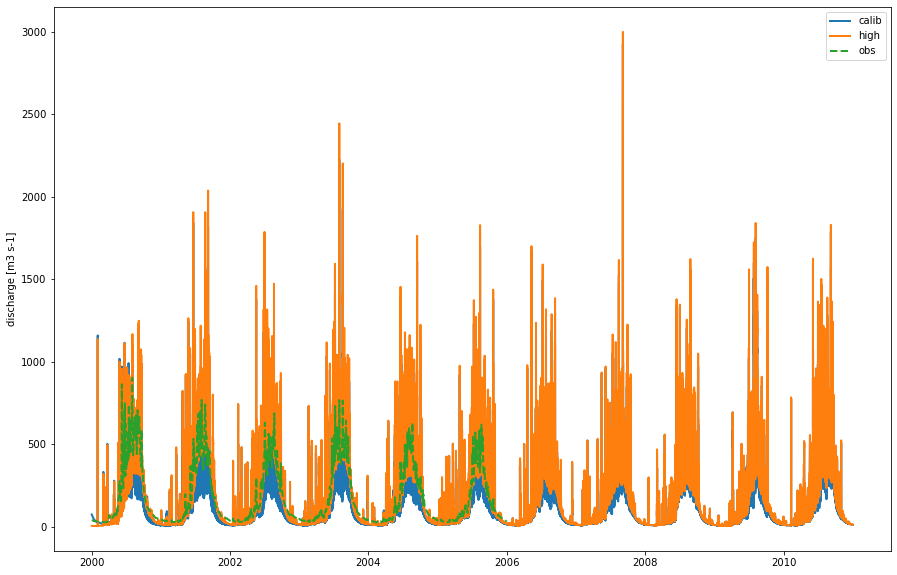

In [163]:
calib.optimizer.calculate_goal_function(result_params) # reset the parameters to the values of the calibration
parameters.pt.albedo = 0.6 # setting a higher value for st.ts
s_init = state.extract_state([])
# type(state)
# s0=state_repos.get_state(0)
# s0.state_vector
# state.apply_state(s0, [])
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
#parameters.st.lwmax = 0.0 # setting a lower value for st.ts

#calib.run(state=s_init) # rerun the model, with new parameter

#disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
calib.run(state=s_init) 
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps_sim, disch_sim.values, lw=2, label = "calib")
ax.plot(ts_timestamps_sim, disch_sim_p_high.values, lw=2, label = "high")
#ax.plot(ts_timestamps_sim, disch_sim_p_low.values, lw=2, label = "low")
ax.plot(ts_timestamps_obs, disch_obs, lw=2, ls='--', label = "obs")
#ax.set_title("investigating parameter st.tx")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

/tmp/ipykernel_525335/3319615403.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


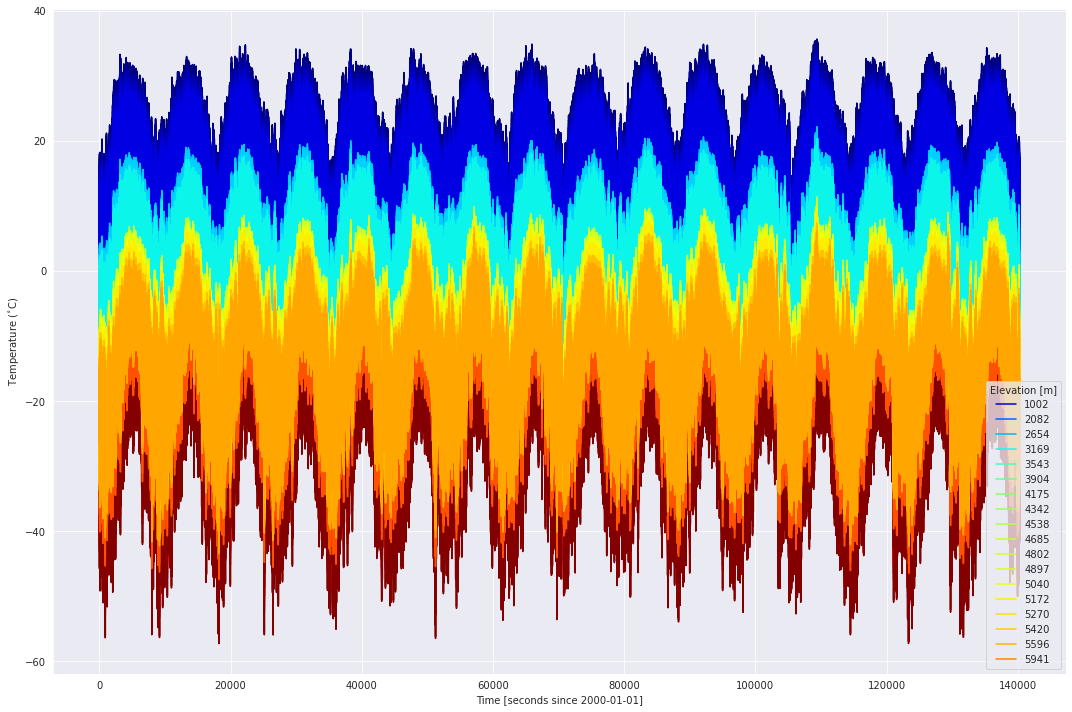

In [9]:
from matplotlib.cm import jet as jet
from matplotlib.colors import Normalize
import seaborn as sns 
sns.set_style('darkgrid')
# get all the cells for one sub-catchment with 'id' == 1228
c10 = [c for c in region_model.cells if c.geo.catchment_id() == 10]

# for plotting, create an mpl normalizer based on min,max elevation
elv = [c.geo.mid_point().z for c in c10]
norm = Normalize(min(elv), max(elv))

#plot with line color a function of elevation
fig, ax = plt.subplots(figsize=(15,10))

# here we are cycling through each of the cells in c1228
for dat,elv in zip([c.env_ts.temperature.values for c in c10], [c.mid_point().z for c in c10]):
    ax.plot(dat, color=jet(norm(elv)), label=int(elv))
    
    
# the following is just to plot the legend entries and not related to Shyft
handles, labels = ax.get_legend_handles_labels()

# sort by labels
import operator
hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
handles2, labels2 = zip(*hl)

# show legend, but only every fifth entry
ax.legend(handles2[::60], labels2[::60], title='Elevation [m]')
ax.set_ylabel('Temperature ($^{\circ}$C)')
ax.set_xlabel('Time [seconds since 2000-01-01]')
plt.tight_layout()
plt.show()

In [17]:
temp = [c.env_ts.temperature.values for c in c10]
precip = [c.env_ts.precipitation.values for c in c10]
radiation = [c.env_ts.radiation.values for c in c10]
rel_hum = [c.env_ts.rel_hum.values for c in c10]
wind_speed = [c.env_ts.wind_speed.values for c in c10]
x = [c.mid_point().x for c in c10]
y = [c.mid_point().y for c in c10]
z = [c.mid_point().z for c in c10]
timestamps = [region_model.time_axis.time(i) for i in range(0, region_model.time_axis.n)]
ts_timestamps = [datetime.datetime.utcfromtimestamp(p.seconds) for p in timestamps]

In [20]:
print(len(ts_timestamps))

140256


In [19]:
np.shape(temp)

(1071, 140256)

In [ ]:
t

In [22]:
import xarray as xr

ds = xr.Dataset(
    data_vars= dict(
        temp = (('cell', 'time'), temp),
        precip = (('cell', 'time'), precip),
        radiation = (('cell', 'time'), radiation),
        rel_hum = (('cell', 'time'), rel_hum),
        wind = (('cell', 'time'), wind_speed),
    ),
    coords= dict(
        time = (('time'), ts_timestamps),
        x = (('cell'), x),
        y = (('cell'), y),
        z = (('cell'), z)
    )
)

ds

<xarray.Dataset>
Dimensions:    (cell: 1071, time: 140256)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 ... 2015-12-31T23:00:00
    x          (cell) float64 2.647e+05 2.658e+05 ... 2.626e+05 2.597e+05
    y          (cell) float64 3.201e+06 3.201e+06 ... 3.2e+06 3.192e+06
    z          (cell) float64 5.243e+03 5.261e+03 ... 5.51e+03 5.717e+03
Dimensions without coordinates: cell
Data variables:
    temp       (cell, time) float64 -23.92 -24.38 -23.59 ... -31.05 -30.52
    precip     (cell, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    radiation  (cell, time) float64 0.0 36.07 208.1 418.7 ... 0.0 0.0 0.0 0.0
    rel_hum    (cell, time) float64 0.6876 0.6876 0.6785 ... 0.4291 0.4153
    wind       (cell, time) float64 1.469 1.545 1.518 ... 1.615 1.685 1.689

In [23]:
ds.to_netcdf('tin_1071_ptgsk.nc')